## Lab 4 z Podstaw Uczenia Maszynowego - Klasyfikator SVM
### Autor: Dominik Pabiniak
### Nr indeksu: 254397

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

def sensitivity(m_p):
    return round((m_p[0][0]/(m_p[0][0] + m_p[0][1])), 4)
def specificity(m_p):
    return round((m_p[1][1]/(m_p[1][0] + m_p[1][1])), 4)

def plot_class(X_syn_test, y_pred, model, method):
        X_pred_0 = X_syn_test[y_pred == 0]
        X_pred_1 = X_syn_test[y_pred == 1]
        x_min, x_max = X_syn_test[:, 0].min() - 0.2, X_syn_test[:, 0].max() + 0.2
        y_min, y_max = X_syn_test[:, 1].min() - 0.2, X_syn_test[:, 1].max() + 0.2
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, alpha=0.2)
        plt.scatter(X_pred_0[:, 0], X_pred_0[:, 1], marker='.', label='Klasa 1')
        plt.scatter(X_pred_1[:, 0], X_pred_1[:, 1], marker='.', label='Klasa 2')
        plt.title(f'Powierzchnia decyzyjna {method}')
        plt.xlabel('Cecha 1')
        plt.ylabel('Cecha 2')
        plt.legend()


def plot_class_poly(X_syn_test, X_pred_0, X_pred_1, model, method, poly):
    x_min, x_max = X_syn_test[:, 0].min() - 0.2, X_syn_test[:, 0].max() + 0.2
    y_min, y_max = X_syn_test[:, 1].min() - 0.2, X_syn_test[:, 1].max() + 0.2
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000), np.linspace(y_min, y_max, 1000))
    Z1 = np.c_[xx.ravel(), yy.ravel()]
    ZP = poly.transform(Z1)
    Z = model.predict(ZP)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.2)
    plt.scatter(X_pred_0[:, 0], X_pred_0[:, 1], marker='.', label='Klasa 1')
    plt.scatter(X_pred_1[:, 0], X_pred_1[:, 1], marker='.', label='Klasa 2')
    plt.title(f'Powierzchnia decyzyjna {method}')
    plt.xlabel('Cecha 1')
    plt.ylabel('Cecha 2')
    plt.legend()

In [11]:
from scipy.optimize import minimize
from itertools import product
from scipy.optimize import LinearConstraint


class MSVC():
    def __init__(self, C=1, kernel='linear', degree=3, gamma=1,
                tol=None, max_iter=10):
        self.C = C
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.tol = tol
        self.max_iter = max_iter
        
        self.alphas = None
        self.X = None
        self.y = None
        self.b = None

    def fit(self, X, y):
        y[y == 0] = -1
        initial_alphas = np.repeat(0, X.shape[0])
        alphas_bounds = [(0, np.inf) for _ in range(X.shape[0])]
        constraint1 = LinearConstraint(y, 0, 0)
        constraint2 = LinearConstraint(np.ones((X.shape[0],)), 0, self.C)

        res = minimize(
            self._loss,
            initial_alphas,
            method='trust-constr',
            args=(X, y, self._kernel_matrix),
            bounds=alphas_bounds,
            constraints=(constraint1, constraint2),
            tol=self.tol,
            options={'maxiter': self.max_iter}
        )

        alphas = res.x

        self.alphas = alphas
        self.X = X
        self.y = y
        self.b = self._calc_bias(alphas, y, X)
    
    def _loss(self, alphas, X, y, kernel_fun):
        n = alphas.size
        L = 0
        for i, j in product(range(n), range(n)):
            L += -alphas[i] + 0.5*(alphas[i]*alphas[j]*y[i]*y[j]*kernel_fun(X[i], X[j]))
        return L

    
    def _calc_bias(self, alphas, ys, xs):
        n = xs.shape[0]
        bias_sum = 0
        for i in range(n):
            bias_part = ys[i] - sum((alphas[j] * ys[j] * self._kernel_matrix(xs[i], xs[j]) for j in range(n)))
            bias_sum += bias_part
        return bias_sum / n
    

    def _kernel_matrix(self, A, B):
        if self.kernel == 'rbf':
            return self._rbf_kernel(A, B)
        elif self.kernel == 'poly':
            return self._poly_kernel(A, B)
        elif self.kernel == 'linear':
            return self._linear_kernel(A, B)
        else:
            raise ValueError("Kernel not supported")
    
    def _linear_kernel(self, A, B):
        return A @ B

    def _poly_kernel(self, A, B):
        return (A @ B + 1) ** self.degree
    
    def _rbf_kernel(self, A, B):
        return np.exp(-self.gamma*np.sqrt((A-B)@(A-B)))

    def decision_function(self, X):
        n = self.X.shape[0]
        kernel_fun = np.vectorize(self._kernel_matrix, signature='(n),(n)->()')
        sum_parts = (self.alphas[i] * self.y[i] * kernel_fun(self.X[i], X) for i in range(n))
        sum_value = sum(sum_parts)
        result = sum_value + self.b
        return result

    def predict(self, X):
        return self.decision_function(X) > 0

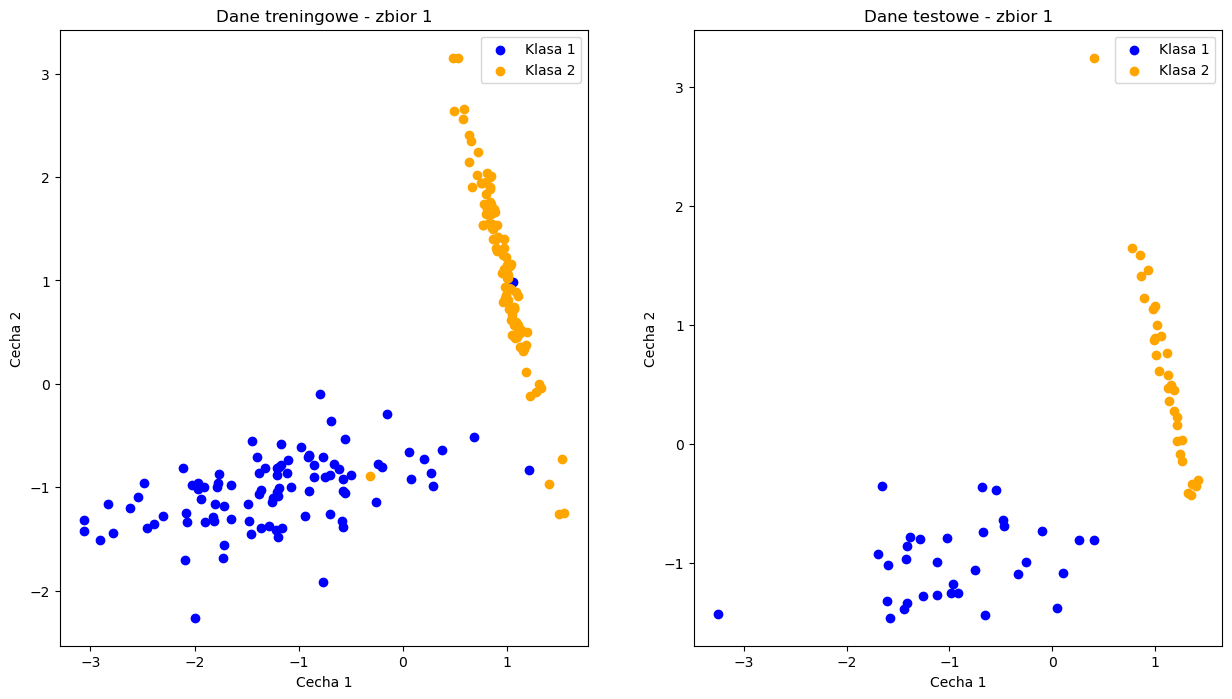

In [23]:
scaler = MinMaxScaler()
# Dane wejsciowe
X, t = make_classification(n_samples=259, n_features=2, n_clusters_per_class=1, n_redundant=0, random_state=254397)

#Podzial na podzbiory
X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(X, t, test_size=0.25, random_state=254397)


# Podzial zbiorow na klasy w celu ich wyswietlenia
klasa_0_train = X_syn_train[(y_syn_train == 0)]
klasa_1_train = X_syn_train[(y_syn_train == 1)]
klasa_0_test = X_syn_test[(y_syn_test == 0)]
klasa_1_test = X_syn_test[(y_syn_test == 1)]

# Wyswietlenie danych
_, axs = plt.subplots(1, 2, figsize=(15, 8))
ax = axs[0]
ax.scatter(klasa_0_train[:,0], klasa_0_train[:,1], c = "blue", label="Klasa 1")
ax.scatter(klasa_1_train[:,0], klasa_1_train[:,1], c = "orange", label="Klasa 2")
ax.set_title("Dane treningowe - zbior 1")
ax.set_xlabel("Cecha 1")
ax.set_ylabel("Cecha 2")
ax.legend()

ax = axs[1]
ax.scatter(klasa_0_test[:,0], klasa_0_test[:,1], c = "blue", label="Klasa 1")
ax.scatter(klasa_1_test[:,0], klasa_1_test[:,1], c = "orange", label="Klasa 2")
ax.set_title("Dane testowe - zbior 1")
ax.set_xlabel("Cecha 1")
ax.set_ylabel("Cecha 2")
ax.legend()

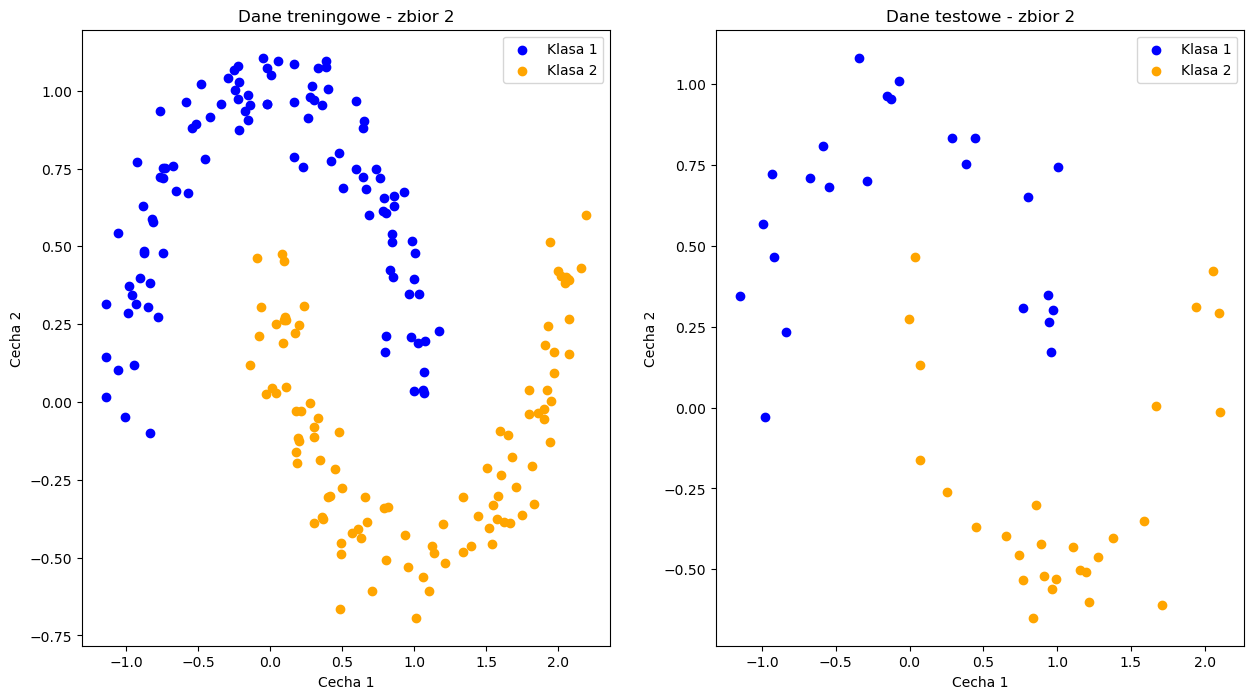

In [16]:
from sklearn.datasets import make_moons

# Dane wejsciowe
X_m, t_m = make_moons(n_samples=259, random_state=254397, noise=0.1)

#Podzial na podzbiory
X_train_M, X_test_M, y_train_M, y_test_M = train_test_split(X_m, t_m, test_size=.2, random_state=254397)

# Podzial zbiorow na klasy w celu ich wyswietlenia
klasa_0_train_M = X_train_M[(y_train_M == 0)]
klasa_1_train_M = X_train_M[(y_train_M == 1)]
klasa_0_test_M = X_test_M[(y_test_M == 0)]
klasa_1_test_M = X_test_M[(y_test_M == 1)]

# Wyswietlenie danych
_, axs = plt.subplots(1, 2, figsize=(15, 8))
ax = axs[0]
ax.scatter(klasa_0_train_M[:,0], klasa_0_train_M[:,1], c = "blue", label="Klasa 1")
ax.scatter(klasa_1_train_M[:,0], klasa_1_train_M[:,1], c = "orange", label="Klasa 2")
ax.set_title("Dane treningowe - zbior 2")
ax.set_xlabel("Cecha 1")
ax.set_ylabel("Cecha 2")
ax.legend()

ax = axs[1]
ax.scatter(klasa_0_test_M[:,0], klasa_0_test_M[:,1], c = "blue", label="Klasa 1")
ax.scatter(klasa_1_test_M[:,0], klasa_1_test_M[:,1], c = "orange", label="Klasa 2")
ax.set_title("Dane testowe - zbior 2")
ax.set_xlabel("Cecha 1")
ax.set_ylabel("Cecha 2")
ax.legend()

Sredni czas metody sklearn linear: 0.0006809687614440918 s
Czas metody linear: 92.78338837623596 s

Metoda Sklearn Linear:
Macierz pomylek: 
[[33  0]
 [ 0 32]]
Dokladnosc: 1.0
Czulosc: 1.0
Swoistosc: 1.0

Metoda Custom Linear:
Macierz pomylek: 
[[31  2]
 [ 0 32]]
Dokladnosc: 0.9692307692307692
Czulosc: 0.9394
Swoistosc: 1.0


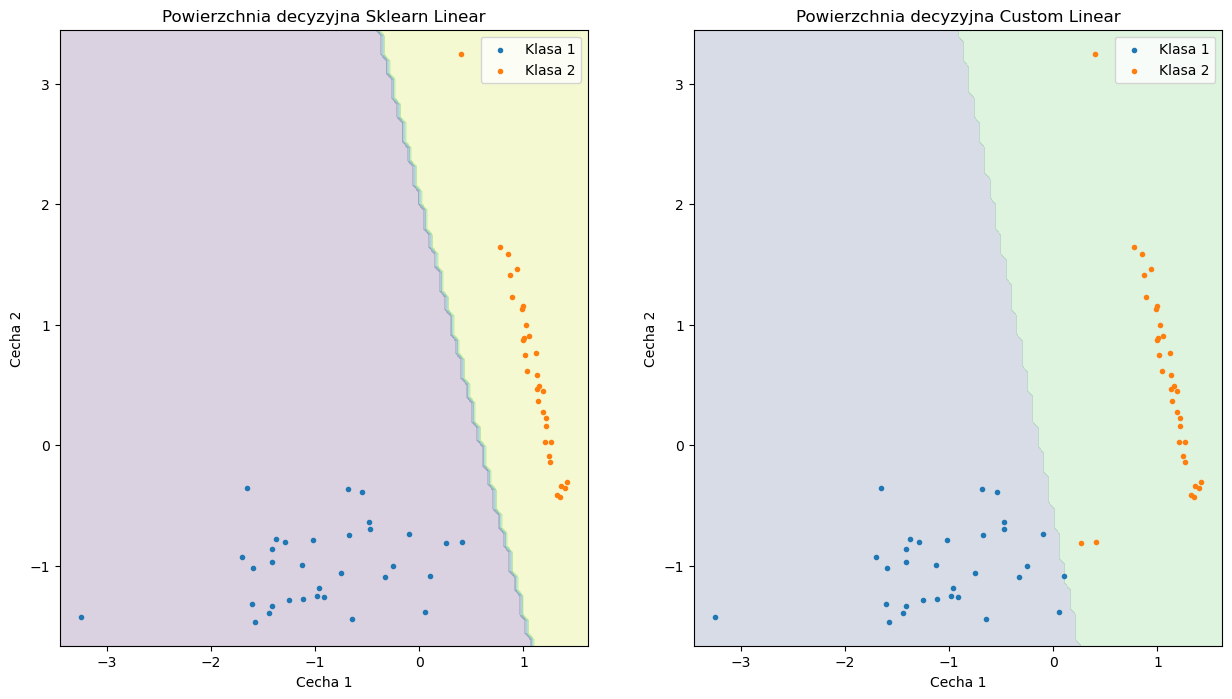

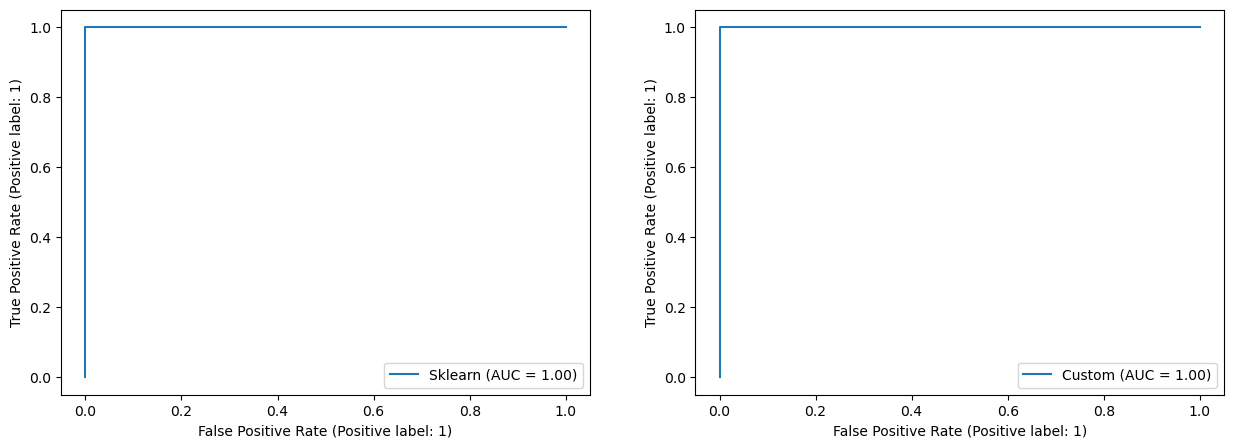

In [21]:
import time
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay

# Linear sklearn
svm_classifier_linear = SVC(kernel='linear')
start = time.time()
for i in range(100):
    svm_classifier_linear.fit(X_syn_train, y_syn_train)
    y_syn_pred_linear = svm_classifier_linear.predict(X_syn_test)
end = time.time()
print(f'Sredni czas metody sklearn linear: {(end - start)/100} s')

# Wlasna metoda linear
msvm_linear = MSVC(kernel='linear', C=100.0, gamma=1, tol=1e-20, max_iter=10)
start = time.time()
msvm_linear.fit(X_syn_train, y_syn_train)
y_pred_linear = msvm_linear.predict(X_syn_test)
end = time.time()
print(f'Czas metody linear: {(end - start)} s')

# Wyniki metod
accuracy_linear = accuracy_score(y_syn_test, y_syn_pred_linear)
c_matrix_linear = confusion_matrix(y_syn_test, y_syn_pred_linear)
print('\nMetoda Sklearn Linear:')
print(f'Macierz pomylek: \n{c_matrix_linear}')
print(f'Dokladnosc: {accuracy_linear}\nCzulosc: {sensitivity(c_matrix_linear)}\nSwoistosc: {specificity(c_matrix_linear)}')

accuracy_linear1 = accuracy_score(y_syn_test, y_pred_linear)
c_matrix_linear2 = confusion_matrix(y_syn_test, y_pred_linear)
print('\nMetoda Custom Linear:')
print(f'Macierz pomylek: \n{c_matrix_linear2}')
print(f'Dokladnosc: {accuracy_linear1}\nCzulosc: {sensitivity(c_matrix_linear2)}\nSwoistosc: {specificity(c_matrix_linear2)}')

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plot_class(X_syn_test, y_syn_pred_linear, svm_classifier_linear, 'Sklearn Linear')
plt.subplot(1, 2, 2)
plot_class(X_syn_test, y_pred_linear, msvm_linear, 'Custom Linear')

y_scores_linear1 = svm_classifier_linear.decision_function(X_syn_test)
y_scores_linear2 = msvm_linear.decision_function(X_syn_test)

_, axs = plt.subplots(1, 2, figsize=(15, 5))
RocCurveDisplay.from_predictions(y_syn_test, y_scores_linear1, name='Sklearn', ax=axs[0])
RocCurveDisplay.from_predictions(y_syn_test, y_scores_linear2, name='Custom', ax=axs[1])

Sredni czas metody sklearn RBF: 0.0006577968597412109 s
Sredni czas metody sklearn RBF: 0.0005382013320922852 s

Metoda RBF:
Macierz pomylek: 
[[33  0]
 [ 0 32]]
Dokladnosc: 1.0
Czulosc: 1.0
Swoistosc: 1.0

Metoda Poly:
Macierz pomylek: 
[[33  0]
 [ 0 32]]
Dokladnosc: 1.0
Czulosc: 1.0
Swoistosc: 1.0


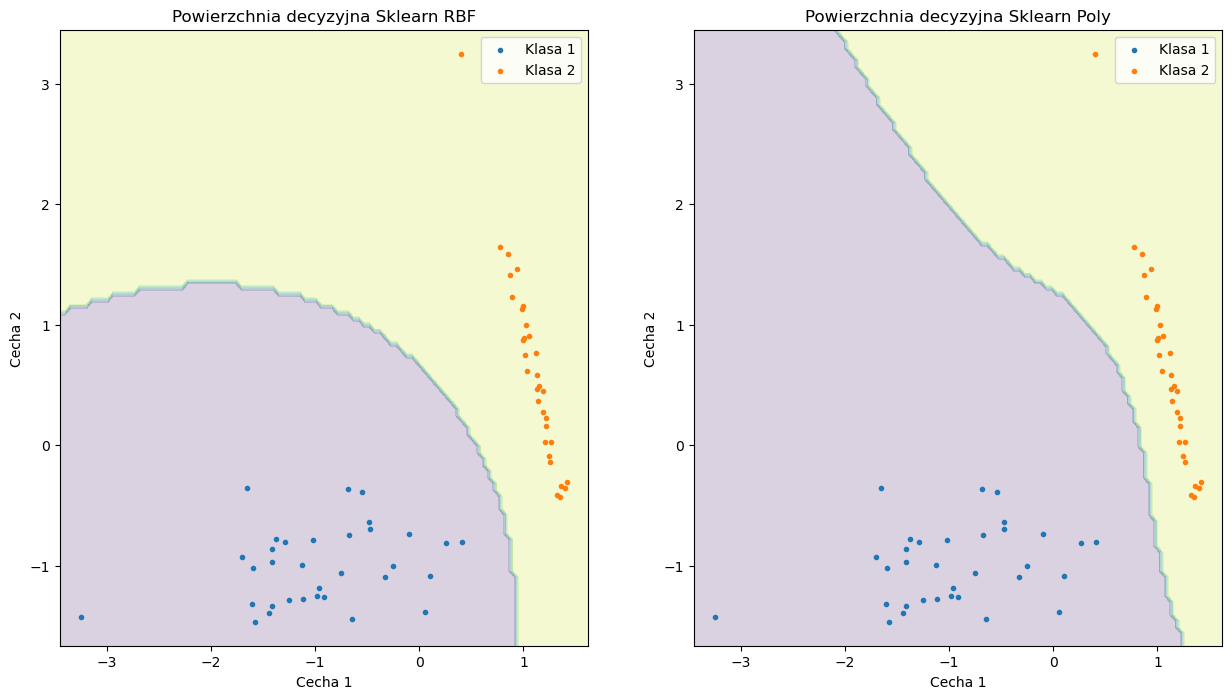

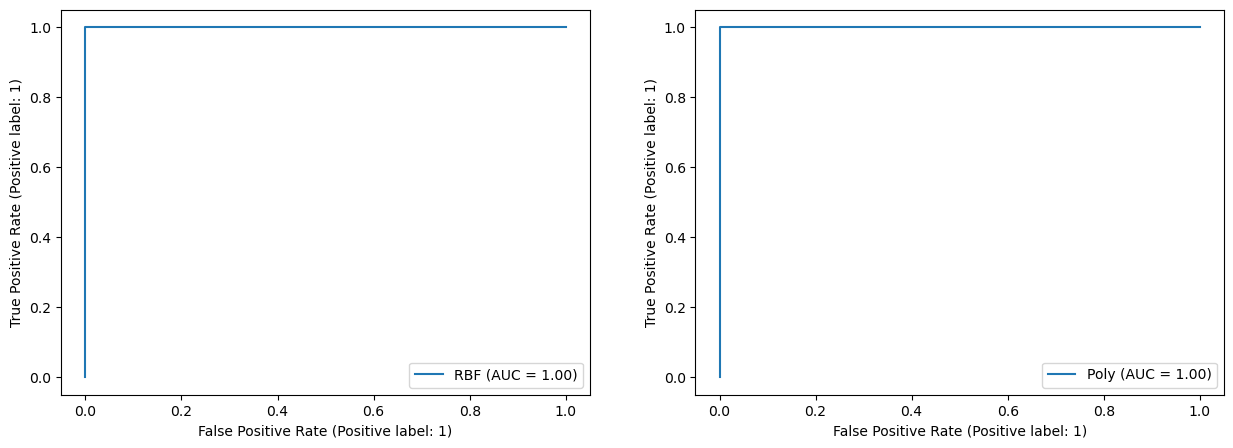

In [24]:
# scaler = MinMaxScaler()
# X_syn_train = scaler.fit_transform(X_syn_train)
# X_syn_test = scaler.transform(X_syn_test)

# RBF
svm_classifier = SVC(kernel='rbf')
start = time.time()
for i in range(100):
    svm_classifier.fit(X_syn_train, y_syn_train)
    y_syn_pred = svm_classifier.predict(X_syn_test)
end = time.time()
print(f'Sredni czas metody sklearn RBF: {(end - start)/100} s')

# Poly
svm_classifier_poly = SVC(kernel='poly')
start = time.time()
for i in range(100):
    svm_classifier_poly.fit(X_syn_train, y_syn_train)
    y_syn_pred_poly = svm_classifier_poly.predict(X_syn_test)
end = time.time()
print(f'Sredni czas metody sklearn RBF: {(end - start)/100} s')

# Wyniki metod
accuracy_RBF = accuracy_score(y_syn_test, y_syn_pred)
c_matrix_rbf = confusion_matrix(y_syn_test, y_syn_pred)
print('\nMetoda RBF:')
print(f'Macierz pomylek: \n{c_matrix_rbf}')
print(f'Dokladnosc: {accuracy_RBF}\nCzulosc: {sensitivity(c_matrix_rbf)}\nSwoistosc: {specificity(c_matrix_rbf)}')

accuracy_poly = accuracy_score(y_syn_test, y_syn_pred_poly)
c_matrix_poly = confusion_matrix(y_syn_test, y_syn_pred_poly)
print('\nMetoda Poly:')
print(f'Macierz pomylek: \n{c_matrix_poly}')
print(f'Dokladnosc: {accuracy_poly}\nCzulosc: {sensitivity(c_matrix_poly)}\nSwoistosc: {specificity(c_matrix_poly)}')


plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plot_class(X_syn_test, y_syn_pred, svm_classifier, 'Sklearn RBF')
plt.subplot(1, 2, 2)
plot_class(X_syn_test, y_syn_pred_poly, svm_classifier_poly, 'Sklearn Poly')

y_scores_rbf = svm_classifier.decision_function(X_syn_test)
y_scores_poly = svm_classifier_poly.decision_function(X_syn_test)

_, axs = plt.subplots(1, 2, figsize=(15, 5))
RocCurveDisplay.from_predictions(y_syn_test, y_scores_rbf, name='RBF', ax=axs[0])
RocCurveDisplay.from_predictions(y_syn_test, y_scores_poly, name='Poly', ax=axs[1])

Sredni czas metody sklearn RBF: 0.0008589029312133789 s
Sredni czas metody sklearn RBF: 17.516249656677246 s

Metoda RBF:
Macierz pomylek: 
[[24  0]
 [ 0 28]]
Dokladnosc: 1.0
Czulosc: 1.0
Swoistosc: 1.0

Metoda Poly:
Macierz pomylek: 
[[24  0]
 [ 1 27]]
Dokladnosc: 0.9807692307692307
Czulosc: 1.0
Swoistosc: 0.9643


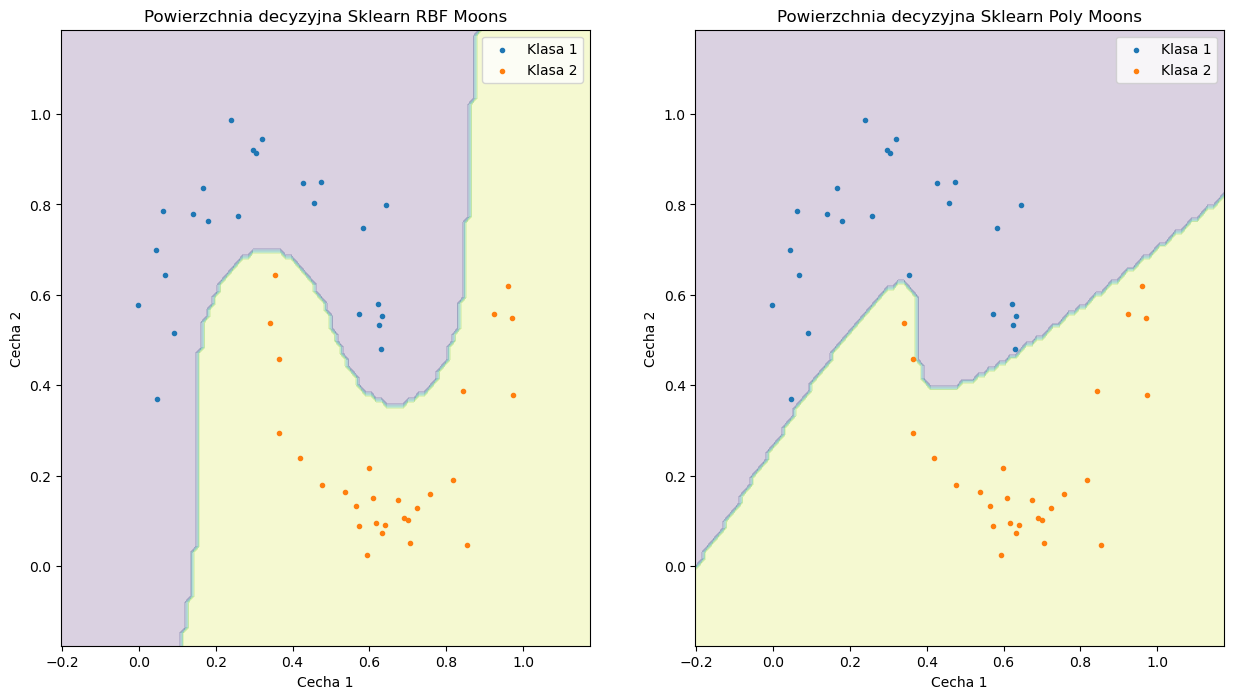

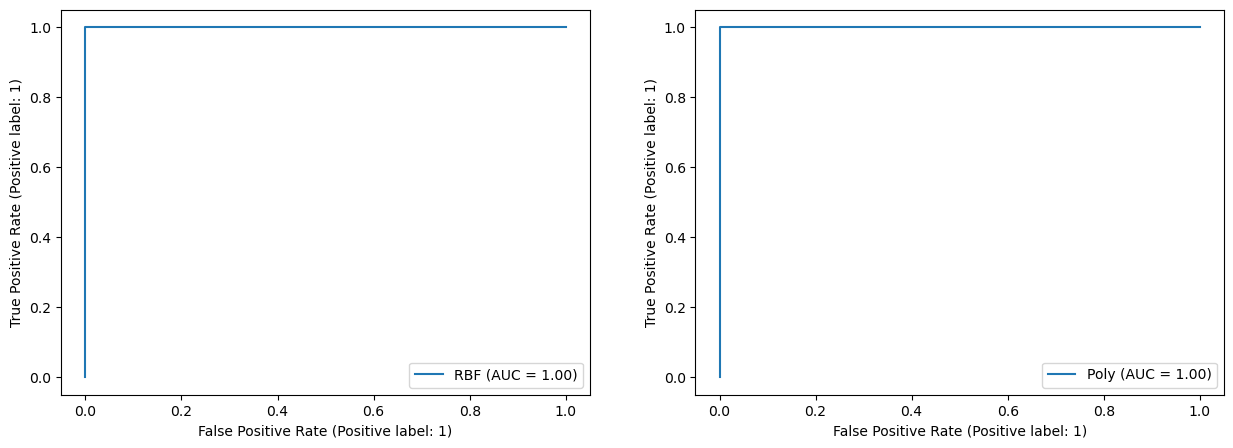

In [25]:
X_train_M = scaler.fit_transform(X_train_M)
X_test_M = scaler.transform(X_test_M)

# RBF
svm_classifier_m = SVC(kernel='rbf')
start = time.time()
for i in range(100):
    svm_classifier_m.fit(X_train_M, y_train_M)
    y_pred_M = svm_classifier_m.predict(X_test_M)
end = time.time()
print(f'Sredni czas metody sklearn RBF: {(end - start)/100} s')


# Poly
svm_classifier_mp = SVC(kernel='poly', degree=3, C=1e10)
start = time.time()
svm_classifier_mp.fit(X_train_M, y_train_M)
y_pred_mp = svm_classifier_mp.predict(X_test_M)
end = time.time()
print(f'Sredni czas metody sklearn RBF: {(end - start)} s')


# Wyniki metod
accuracy_RBF_M = accuracy_score(y_test_M, y_pred_M)
c_matrix_rbf_M = confusion_matrix(y_test_M, y_pred_M)
print('\nMetoda RBF:')
print(f'Macierz pomylek: \n{c_matrix_rbf_M}')
print(f'Dokladnosc: {accuracy_RBF_M}\nCzulosc: {sensitivity(c_matrix_rbf_M)}\nSwoistosc: {specificity(c_matrix_rbf_M)}')

accuracy_poly_M = accuracy_score(y_test_M, y_pred_mp)
c_matrix_poly_M = confusion_matrix(y_test_M, y_pred_mp)
print('\nMetoda Poly:')
print(f'Macierz pomylek: \n{c_matrix_poly_M}')
print(f'Dokladnosc: {accuracy_poly_M}\nCzulosc: {sensitivity(c_matrix_poly_M)}\nSwoistosc: {specificity(c_matrix_poly_M)}')



plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plot_class(X_test_M, y_pred_M, svm_classifier_m, 'Sklearn RBF Moons')
plt.subplot(1, 2, 2)
plot_class(X_test_M, y_pred_mp, svm_classifier_mp, 'Sklearn Poly Moons')

y_scores_rbf_M = svm_classifier_m.decision_function(X_test_M)
y_scores_poly_M = svm_classifier_mp.decision_function(X_test_M)

_, axs = plt.subplots(1, 2, figsize=(15, 5))
RocCurveDisplay.from_predictions(y_test_M, y_scores_rbf_M, name='RBF', ax=axs[0])
RocCurveDisplay.from_predictions(y_test_M, y_scores_poly_M, name='Poly', ax=axs[1])

Czas metody RBF: 190.00393724441528 s
Czas metody RBF: 98.90251803398132 s

Metoda RBF:
Macierz pomylek: 
[[33  0]
 [ 0 32]]
Dokladnosc: 1.0
Czulosc: 1.0
Swoistosc: 1.0

Metoda Poly:
Macierz pomylek: 
[[31  2]
 [ 0 32]]
Dokladnosc: 0.9692307692307692
Czulosc: 0.9394
Swoistosc: 1.0


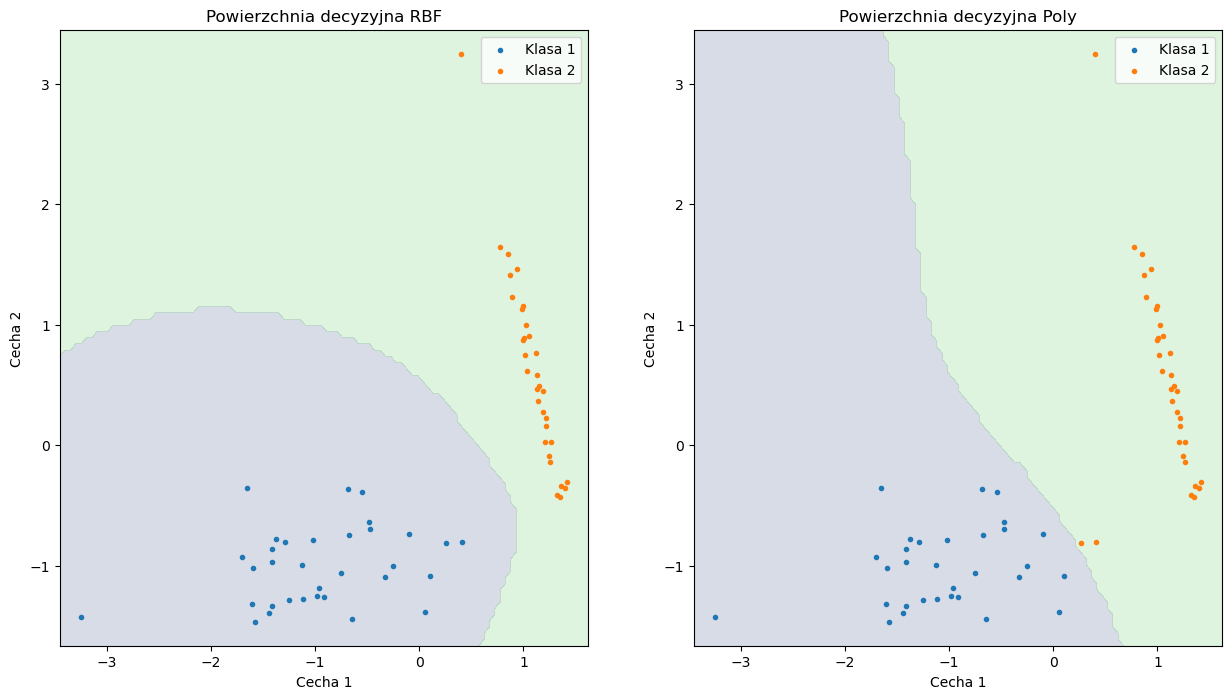

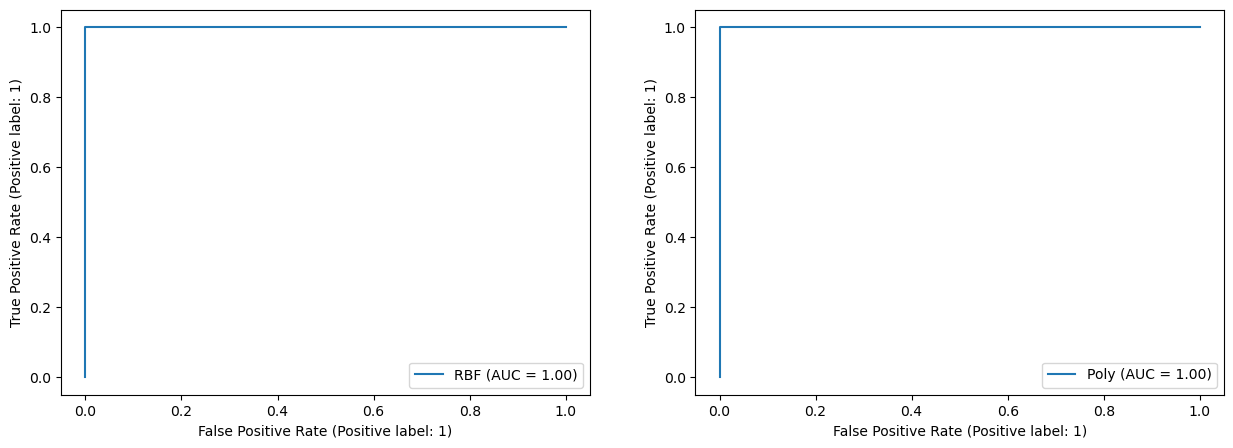

In [9]:
msvm_rbf1 = MSVC(kernel='rbf', C=100.0, gamma=1, tol=1e-20, max_iter=10)

start = time.time()
msvm_rbf1.fit(X_syn_train, y_syn_train)
y_pred_rbf1 = msvm_rbf1.predict(X_syn_test)
end = time.time()
print(f'Czas metody RBF: {(end - start)} s')

msvm_poly1 = MSVC(kernel='poly', C=1e10, gamma=1, tol=1e-20, max_iter=10)

start = time.time()
msvm_poly1.fit(X_syn_train, y_syn_train)
y_pred_poly1 = msvm_poly1.predict(X_syn_test)
end = time.time()
print(f'Czas metody RBF: {(end - start)} s')

accuracy_rbf1 = accuracy_score(y_syn_test, y_pred_rbf1)
c_matrix_rbf1 = confusion_matrix(y_syn_test, y_pred_rbf1)
print('\nMetoda RBF:')
print(f'Macierz pomylek: \n{c_matrix_rbf1}')
print(f'Dokladnosc: {accuracy_rbf1}\nCzulosc: {sensitivity(c_matrix_rbf1)}\nSwoistosc: {specificity(c_matrix_rbf1)}')

accuracy_poly1 = accuracy_score(y_syn_test, y_pred_poly1)
c_matrix_poly1 = confusion_matrix(y_syn_test, y_pred_poly1)
print('\nMetoda Poly:')
print(f'Macierz pomylek: \n{c_matrix_poly1}')
print(f'Dokladnosc: {accuracy_poly1}\nCzulosc: {sensitivity(c_matrix_poly1)}\nSwoistosc: {specificity(c_matrix_poly1)}')


plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plot_class(X_syn_test, y_pred_rbf1, msvm_rbf1, 'RBF')
plt.subplot(1, 2, 2)
plot_class(X_syn_test, y_pred_poly1, msvm_poly1, 'Poly')

y_scores_rbf1 = msvm_rbf1.decision_function(X_syn_test)
y_scores_poly1 = msvm_poly1.decision_function(X_syn_test)

_, axs = plt.subplots(1, 2, figsize=(15, 5))
RocCurveDisplay.from_predictions(y_syn_test, y_scores_rbf1, name='RBF', ax=axs[0])
RocCurveDisplay.from_predictions(y_syn_test, y_scores_poly1, name='Poly', ax=axs[1])

Czas metody RBF: 2.335296022891998 s
Czas metody RBF: 119.00809860229492 s

Metoda RBF:
Macierz pomylek: 
[[24  0]
 [ 0 28]]
Dokladnosc: 1.0
Czulosc: 1.0
Swoistosc: 1.0

Metoda Poly:
Macierz pomylek: 
[[18  6]
 [ 2 26]]
Dokladnosc: 0.8461538461538461
Czulosc: 0.75
Swoistosc: 0.9286


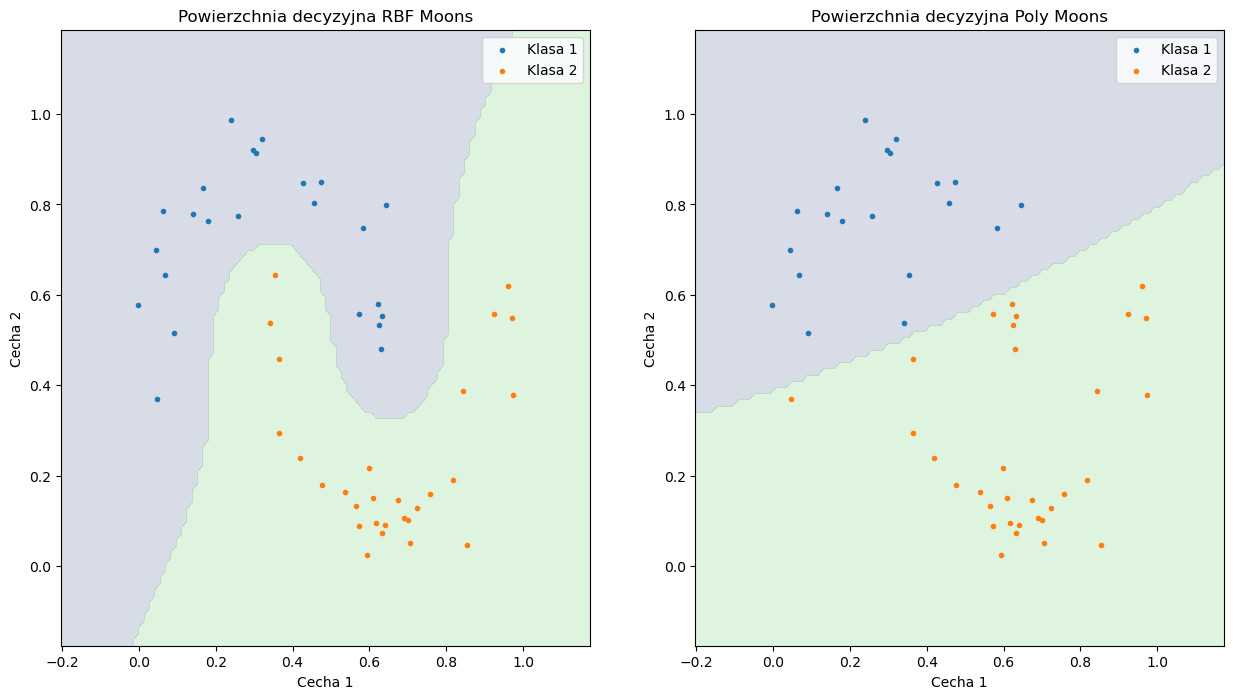

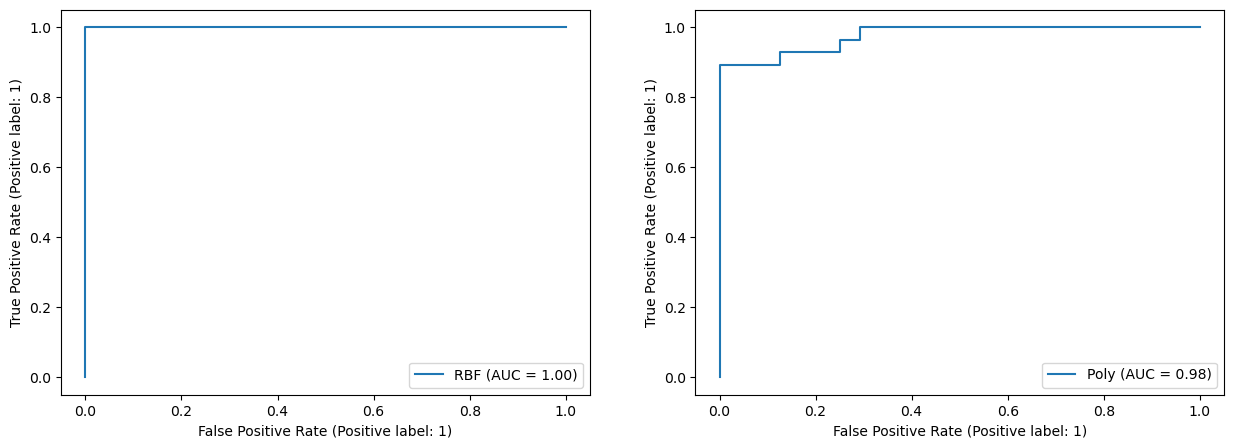

In [26]:
# X_train_M = scaler.fit_transform(X_train_M)
# X_test_M = scaler.transform(X_test_M)

# RBF
svm_classifier_m = MSVC(kernel='rbf', C=100.0, gamma=1, tol=1e-20, max_iter=10)
start = time.time()
svm_classifier_m.fit(X_train_M, y_train_M)
y_pred_M = svm_classifier_m.predict(X_test_M)
end = time.time()
print(f'Czas metody RBF: {(end - start)/100} s')


# Poly
svm_classifier_mp = MSVC(kernel='poly', C=1e10, gamma=1, tol=1e-20, max_iter=10)
start = time.time()
svm_classifier_mp.fit(X_train_M, y_train_M)
y_pred_mp = svm_classifier_mp.predict(X_test_M)
end = time.time()
print(f'Czas metody RBF: {(end - start)} s')


# Wyniki metod
accuracy_RBF_M = accuracy_score(y_test_M, y_pred_M)
c_matrix_rbf_M = confusion_matrix(y_test_M, y_pred_M)
print('\nMetoda RBF:')
print(f'Macierz pomylek: \n{c_matrix_rbf_M}')
print(f'Dokladnosc: {accuracy_RBF_M}\nCzulosc: {sensitivity(c_matrix_rbf_M)}\nSwoistosc: {specificity(c_matrix_rbf_M)}')

accuracy_poly_M = accuracy_score(y_test_M, y_pred_mp)
c_matrix_poly_M = confusion_matrix(y_test_M, y_pred_mp)
print('\nMetoda Poly:')
print(f'Macierz pomylek: \n{c_matrix_poly_M}')
print(f'Dokladnosc: {accuracy_poly_M}\nCzulosc: {sensitivity(c_matrix_poly_M)}\nSwoistosc: {specificity(c_matrix_poly_M)}')



plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plot_class(X_test_M, y_pred_M, svm_classifier_m, 'RBF Moons')
plt.subplot(1, 2, 2)
plot_class(X_test_M, y_pred_mp, svm_classifier_mp, 'Poly Moons')

y_scores_rbf_M = svm_classifier_m.decision_function(X_test_M)
y_scores_poly_M = svm_classifier_mp.decision_function(X_test_M)

_, axs = plt.subplots(1, 2, figsize=(15, 5))
RocCurveDisplay.from_predictions(y_test_M, y_scores_rbf_M, name='RBF', ax=axs[0])
RocCurveDisplay.from_predictions(y_test_M, y_scores_poly_M, name='Poly', ax=axs[1])

In [170]:
import pandas as pd
star_data = pd.read_csv('star_classification_SDSS17.csv')
# Usuwanie niepotrzebnych kolumn
columns_to_drop = ['cam_col', 'MJD', 'obj_ID', 'run_ID', 'field_ID', 'spec_obj_ID', 'fiber_ID', 'rerun_ID']
star_data.drop(columns=columns_to_drop, inplace=True)

# Usuniecie QSO, ze wzgledu na zla macierz korelacji. (wczesniej QSO -> STAR)
# star_data['class'] = star_data['class'].replace('QSO', 'STAR') # Wczesniej
star_data = star_data[star_data['class'] != 'QSO']

# Zamiana wartosci GALAXY -> 1, STAR -> 0
star_data['class'] = star_data['class'].replace(['GALAXY', 'STAR'], [1, 0])

# Sprawdzenie brakujacych wartosci
star_data.isna().sum()

C:\Users\Dominik\AppData\Local\Temp\ipykernel_22796\2840976911.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  star_data['class'] = star_data['class'].replace(['GALAXY', 'STAR'], [1, 0])


alpha       0
delta       0
u           0
g           0
r           0
i           0
z           0
class       0
redshift    0
plate       0
dtype: int64

In [171]:
# Normalizacja danych
star_data = pd.DataFrame(scaler.fit_transform(star_data), columns=star_data.columns)
# Podzial na X i t
X_star = star_data.drop(columns=['class'])
t_star = star_data['class']
X_star_train, X_star_test, y_star_train, y_star_test = train_test_split(X_star, t_star, test_size=0.25, stratify=t_star, random_state=254397)

In [172]:
correlation_matrix = pd.DataFrame(star_data.corr())
correlation_matrix

,alpha,delta,u,g,r,i,z,class,redshift,plate
alpha,1.000000,0.143788,-0.001512,-0.002692,-0.030298,-0.036391,-0.003711,0.017150,-0.033389,-0.014703
delta,0.143788,1.000000,0.003773,0.003870,-0.024545,-0.032801,0.002333,0.000346,-0.021298,0.095854
u,-0.001512,0.003773,1.000000,0.999455,0.055754,0.050049,0.998710,0.023778,0.043348,0.035269
g,-0.002692,0.003870,0.999455,1.000000,0.061225,0.056701,0.999384,0.021976,0.046766,0.040913
r,-0.030298,-0.024545,0.055754,0.061225,1.000000,0.969702,0.047265,0.147360,0.638471,0.668888
i,-0.036391,-0.032801,0.050049,0.056701,0.969702,1.000000,0.048603,0.078462,0.572065,0.665249
z,-0.003711,0.002333,0.998710,0.999384,0.047265,0.048603,1.000000,0.007263,0.028678,0.032740
class,0.017150,0.000346,0.023778,0.021976,0.147360,0.078462,0.007263,1.000000,0.634963,0.090946
redshift,-0.033389,-0.021298,0.043348,0.046766,0.638471,0.572065,0.028678,0.634963,1.000000,0.532657
plate,-0.014703,0.095854,0.035269,0.040913,0.668888,0.665249,0.032740,0.090946,0.532657,1.000000


In [174]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

param_grid = {
            'C': [100, 1000, 10000],
            'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
}

svc_grid = SVC()
grid_search = GridSearchCV(estimator=svc_grid, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=1)
star = time.time()
grid_search.fit(X_star_train, y_star_train)
end = time.time()
print(f'Czas metody GridSearch: {(end - start)} s')

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

y_pred = best_estimator.predict(X_star_test)
print(classification_report(y_star_test, y_pred))

print("Best Parameters:", best_params)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Czas metody GridSearch: 6548.506955385208 s
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      5399
         1.0       1.00      0.99      1.00     14861

    accuracy                           0.99     20260
   macro avg       0.99      1.00      0.99     20260
weighted avg       0.99      0.99      0.99     20260

Best Parameters: {'C': 10000, 'kernel': 'poly'}


In [176]:
accuracy_grid = accuracy_score(y_star_test, y_pred)
c_matrix_grid = confusion_matrix(y_star_test, y_pred)
print('\nMetoda Poly:')
print(f'Macierz pomylek: \n{c_matrix_grid}')
print(f'Dokladnosc: {accuracy_grid}\nCzulosc: {sensitivity(c_matrix_grid)}\nSwoistosc: {specificity(c_matrix_grid)}')
# Dazymy do zmniejszenia liczb FN, ponieważ chcemy wyłapać wszystkie możliwe galaktyki


Metoda Poly:
Macierz pomylek: 
[[ 5398     1]
 [  132 14729]]
Dokladnosc: 0.9934353405725568
Czulosc: 0.9998
Swoistosc: 0.9911
